In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import os
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd
from scipy.stats import skew, kurtosis, moment
from scipy.stats import moment
from sklearn.mixture import GaussianMixture
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [4]:
def plot_ecg(signals,fields, annotation):
    t = np.arange(fields["sig_len"])/fields["fs"]
    plt.figure(figsize=(15,6))
    plt.plot(t,signals[:,0] + 1)
    plt.plot(t,signals[:,1] - 1)
    
    labels = annotation.symbol
    length = annotation.ann_len
    locs = annotation.sample/fields["fs"] # sample locations
    for i in range(length):
        plt.annotate(labels[i],(locs[i],0))
    
    plt.legend(fields["sig_name"])
    plt.xlabel("seconds"); plt.ylabel(fields["units"][0])
    plt.title("Fs:" + str(fields["fs"]) + " Samples:" + str(fields["sig_len"]) 
                           + " Channels:" + str(fields["n_sig"]))
    plt.grid()
    plt.show()
    print(fields["comments"])
    
def plot_unique(signals,fields,labels,locs,delta=150):
    unique, unique_idx = np.unique(labels, return_index=True)

    for idx in unique_idx:
        delta = 150
        plt.plot(signals[locs[idx]-delta:locs[idx]+delta,0] + 1)
        plt.plot(signals[locs[idx]-delta:locs[idx]+delta,1] - 1)
        plt.title(labels[idx] + ":" + labels_dict[labels[idx]])
        plt.legend(fields["sig_name"])
        plt.grid()
        plt.show()

In [5]:
n_list = []
directory = "C:\\Users\\nicol\\Documents\\Jupyter\\mit-bih-arrhythmia-database-1.0.0\\mit-bih-arrhythmia-database-1.0.0"

for file in os.listdir(directory):
    if file.endswith(".dat"):
        n_list.append(int(os.path.splitext(file)[0]))

n_list = np.sort(n_list)
print(n_list)

[100 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118
 119 121 122 123 124 200 201 202 203 205 207 208 209 210 212 213 214 215
 217 219 220 221 222 223 228 230 231 232 233 234]


In [6]:
labels_dict = {
'N': "Normal",
'A': "Atrial premature beat",
'V': "Premature ventricular contraction",
'Q': "Unclassifiable beat",
'f': "Fusion of paced and normal beat",
'J': "Nodal (junctional) premature beat",
'j': "Nodal (junctional) escape beat",
'F': "Fusion of ventricular and normal beat",
'a': "Aberrated atrial premature beat",
'e': "Atrial escape beat",
'L': "Left bundle branch block beat",
'R': "Right bundle branch block beat",
'E': "Ventricular escape beat",
'S': "Supraventricular premature or ectopic beat (atrial or nodal)",

'+': "Rhythm change",
'|': "Isolated QRS-like artifact",
'/': "Paced beat",
'~': "Change in signal quality",
'"': "Comment annotation",
'x': "Non-conducted P-wave (blocked APC)",
'[': "Start of ventricular flutter/fibrillation",
'!': "Ventricular flutter wave",
']': "End of ventricular flutter/fibrillation"
}

In [7]:
n_list

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
       203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
       221, 222, 223, 228, 230, 231, 232, 233, 234])

In [8]:
# n=100

X = []
X_preRR = []; X_postRR = []

Y = []


for n in n_list:
    print(n)    
    signals, fields = wfdb.rdsamp(directory + '/' + str(n))
    annotation = wfdb.rdann(directory + '/' + str(n), 'atr')
    
    if(fields["sig_name"] != ['MLII','V1']):
        continue
        
    labels = annotation.symbol
    length = annotation.ann_len
    locs = annotation.sample # sample locations
    print(fields["sig_name"])
    print(Counter(labels).keys()) 
    print(Counter(labels).values()) 

    
    delta = 150

    for idx,(loc,label) in enumerate(zip(locs,labels)):
        if(loc > 5*delta and loc < fields["sig_len"] - 5*delta):

            # Normal
            if(label in ['N','L','R','e','j']): 
                X.append(signals[loc-delta:loc+delta,:])
                X_preRR.append(locs[idx]-locs[idx-1])
                X_postRR.append(locs[idx+1]-locs[idx])
                Y.append(0)  
            
            # Arrhythmia
            elif(label in ['A','V','J','F','a','E','S']):
                X.append(signals[loc-delta:loc+delta,:])
                X_preRR.append(locs[idx]-locs[idx-1])
                X_postRR.append(locs[idx+1]-locs[idx])
                Y.append(1)

X = np.dstack(X)
X = np.rollaxis(X,-1)
X_preRR = np.array(X_preRR); X_postRR = np.array(X_postRR)
Y = np.array(Y)

100
101
['MLII', 'V1']
dict_keys(['+', 'N', '~', '|', 'Q', 'A'])
dict_values([1, 1860, 4, 4, 2, 3])
102
103
104
105
['MLII', 'V1']
dict_keys(['+', 'N', 'V', '~', '|', 'Q'])
dict_values([1, 2526, 41, 88, 30, 5])
106
['MLII', 'V1']
dict_keys(['~', '+', 'N', 'V'])
dict_values([30, 41, 1507, 520])
107
['MLII', 'V1']
dict_keys(['+', '/', 'V', '~'])
dict_values([1, 2078, 59, 2])
108
['MLII', 'V1']
dict_keys(['+', 'N', 'V', 'x', '~', '|', 'F', 'A', 'j'])
dict_values([1, 1739, 17, 11, 41, 8, 2, 4, 1])
109
['MLII', 'V1']
dict_keys(['+', 'L', 'F', 'V', '~'])
dict_values([1, 2492, 2, 38, 2])
111
['MLII', 'V1']
dict_keys(['+', 'L', '~', 'V'])
dict_values([1, 2123, 8, 1])
112
['MLII', 'V1']
dict_keys(['+', 'N', '~', 'A'])
dict_values([1, 2537, 10, 2])
113
['MLII', 'V1']
dict_keys(['+', 'N', 'a'])
dict_values([1, 1789, 6])
114
115
['MLII', 'V1']
dict_keys(['+', 'N', '~', '|'])
dict_values([1, 1953, 2, 6])
116
['MLII', 'V1']
dict_keys(['+', 'N', 'V', 'A', '~'])
dict_values([1, 2302, 109, 1, 8])
117
1

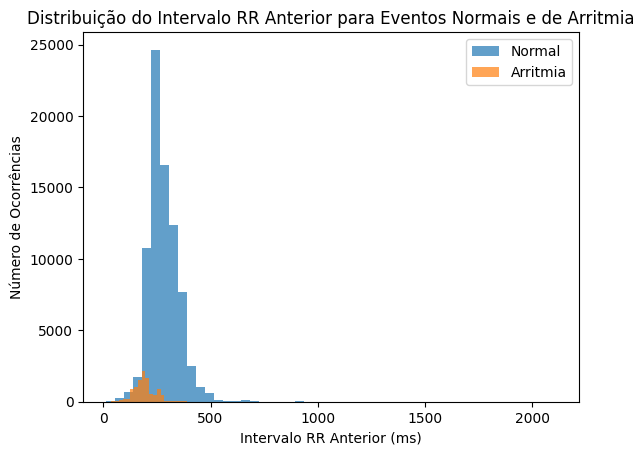

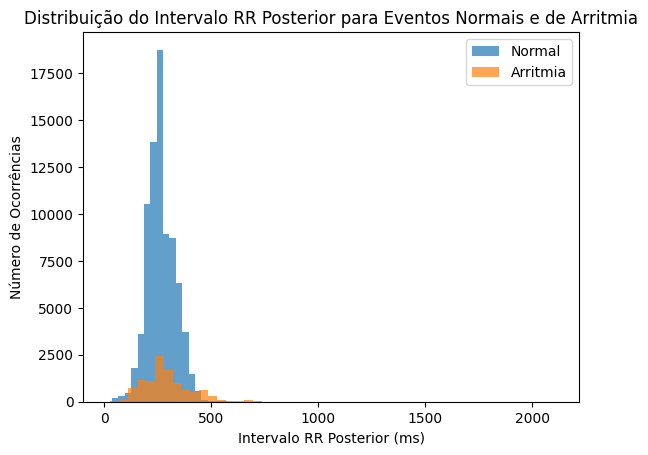

In [9]:
plt.hist(X_preRR[Y==0], bins=50, label='Normal', alpha=0.7)
plt.hist(X_preRR[Y==1], bins=50, label='Arritmia', alpha=0.7)
plt.xlabel('Intervalo RR Anterior (ms)')
plt.ylabel('Número de Ocorrências')
plt.title('Distribuição do Intervalo RR Anterior para Eventos Normais e de Arritmia')
plt.legend()
plt.show()

# Plotagem do Histograma de X_postRR
plt.hist(X_postRR[Y==0], bins=50, label='Normal', alpha=0.7)
plt.hist(X_postRR[Y==1], bins=50, label='Arritmia', alpha=0.7)
plt.xlabel('Intervalo RR Posterior (ms)')
plt.ylabel('Número de Ocorrências')
plt.title('Distribuição do Intervalo RR Posterior para Eventos Normais e de Arritmia')
plt.legend()
plt.show()

In [10]:
def GMM(X):
    gm = GaussianMixture(n_components=2, random_state=0)
    gm.fit(X)
    m = gm.means_ ; w = gm.weights_
    result = [m[0,0],m[0,1],m[1,0],m[1,1],w[0],w[1]]
    return result

In [9]:
def create_feature_vectors(X):
    Xf = []
    
    for i in range(len(X)):
#         if(i%1000==0):
#             print(i)

        gmm_result = GMM(X[i,:,:])
        
        Xf.append([
            X_preRR[i],
            X_postRR[i],
            moment(X[i,:,0], moment = 3),
            moment(X[i,:,0], moment = 4),
            moment(X[i,:,0], moment = 5),
            moment(X[i,:,1], moment = 3),
            moment(X[i,:,1], moment = 4),
            moment(X[i,:,1], moment = 5)]
            + gmm_result
                )
    
    Xf = np.vstack(Xf)
    
    return Xf

In [10]:
# creates the file, use just the first run
#Xf = create_feature_vectors(X)
#Xf = X[:,:,0]
#with open('Xf.pickle', 'wb') as f:
#   pickle.dump(Xf, f)

In [11]:
with open('Xf.pickle', 'rb') as f:
    Xf = pickle.load(f)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(Xf, Y, test_size=0.2, random_state=42)
X_sig_train, X_sig_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [13]:
# standardize
scaler = StandardScaler().fit(X_train) 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
from sklearn.neighbors import KNeighborsClassifier
param_grid = {'n_neighbors':[2,3,4,5,7,10]}
base_estimator = KNeighborsClassifier()
clf = GridSearchCV(base_estimator, param_grid, cv=5, verbose=3)
clf.fit(X_train,y_train)
pd.DataFrame(clf.cv_results_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....................n_neighbors=2;, score=0.987 total time=   7.3s
[CV 2/5] END .....................n_neighbors=2;, score=0.985 total time=   7.0s
[CV 3/5] END .....................n_neighbors=2;, score=0.985 total time=   7.2s
[CV 4/5] END .....................n_neighbors=2;, score=0.987 total time=   6.7s
[CV 5/5] END .....................n_neighbors=2;, score=0.983 total time=   6.9s
[CV 1/5] END .....................n_neighbors=3;, score=0.987 total time=   6.8s
[CV 2/5] END .....................n_neighbors=3;, score=0.986 total time=   6.9s
[CV 3/5] END .....................n_neighbors=3;, score=0.985 total time=   7.1s
[CV 4/5] END .....................n_neighbors=3;, score=0.988 total time=   6.8s
[CV 5/5] END .....................n_neighbors=3;, score=0.984 total time=   6.7s
[CV 1/5] END .....................n_neighbors=4;, score=0.987 total time=   6.8s
[CV 2/5] END .....................n_neighbors=4;,

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.104162,0.002685,7.039657,0.201752,2,{'n_neighbors': 2},0.986885,0.984942,0.984942,0.986954,0.982860,0.985317,0.001514,2
1,0.102801,0.001851,6.862349,0.128581,3,{'n_neighbors': 3},0.987163,0.985705,0.985081,0.987926,0.983971,0.985969,0.001422,1
2,0.096279,0.002489,6.770622,0.212046,4,{'n_neighbors': 4},0.987232,0.984734,0.984248,0.986122,0.983138,0.985095,0.001435,4
3,0.103381,0.003579,6.913923,0.189984,5,{'n_neighbors': 5},0.986746,0.984873,0.984595,0.986746,0.983138,0.985220,0.001379,3
4,0.095737,0.000888,6.875014,0.073380,7,{'n_neighbors': 7},0.986122,0.984526,0.983832,0.985497,0.982236,0.984442,0.001355,5
5,0.101770,0.003230,6.917754,0.219989,10,{'n_neighbors': 10},0.984595,0.982166,0.981819,0.983277,0.979530,0.982277,0.001682,6


In [16]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train,y_train)
with open('modelo.pkl', 'wb') as arquivo:
    pickle.dump(clf, arquivo)

In [17]:
y_hat = clf.predict(X_train)
print(confusion_matrix(y_train, y_hat)) # true, pred
print("Accuracy: ",accuracy_score(y_train, y_hat))
print("F1 Score: ",f1_score(y_train, y_hat))

[[63460   116]
 [  456  8023]]
Accuracy:  0.9920616195961418
F1 Score:  0.9655794921169816


In [18]:
y_hat = clf.predict(X_test)
print(confusion_matrix(y_test, y_hat)) # true, pred
print("Accuracy: ",accuracy_score(y_test, y_hat))
print("F1 Score: ",f1_score(y_test, y_hat))
print(classification_report(y_test, y_hat, digits=4))

[[15842    41]
 [  177  1954]]
Accuracy:  0.9878983013211946
F1 Score:  0.9471643238002908
              precision    recall  f1-score   support

           0     0.9890    0.9974    0.9932     15883
           1     0.9794    0.9169    0.9472      2131

    accuracy                         0.9879     18014
   macro avg     0.9842    0.9572    0.9702     18014
weighted avg     0.9878    0.9879    0.9877     18014



In [19]:
y_hat = clf.predict(X_test)
cm = confusion_matrix(y_test, y_hat)
print(cm)

[[15842    41]
 [  177  1954]]


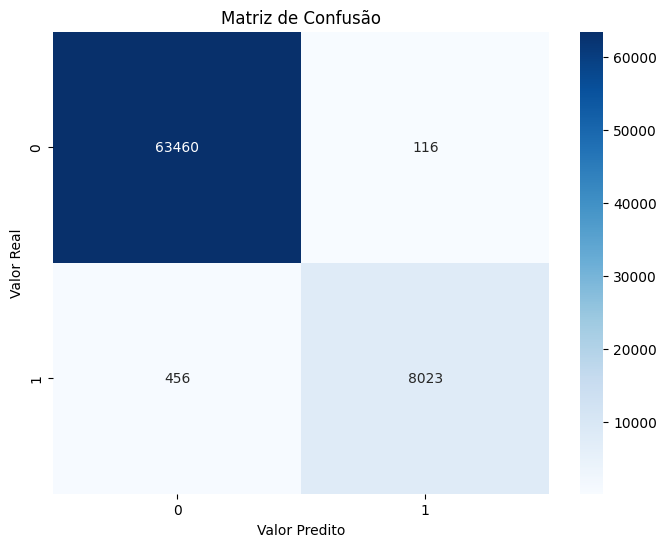

In [20]:
y_hat = clf.predict(X_train)
# Obtendo a matriz de confusão
conf_matrix = confusion_matrix(y_train, y_hat)

# Criando o gráfico da matriz de confusão usando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Matriz de Confusão')
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real')
plt.show()

In [21]:
from sklearn import svm
# Train
clf = svm.SVC(C=10.0, gamma = 1.0, kernel='rbf', degree=3)
clf.fit(X_train,y_train)

In [ ]:
y_hat = clf.predict(X_train)
print(confusion_matrix(y_train, y_hat)) # true, pred
print("Accuracy: ",accuracy_score(y_train, y_hat))
print("F1 Score: ",f1_score(y_train, y_hat))

In [ ]:
y_hat = clf.predict(X_test)
print(confusion_matrix(y_test, y_hat)) # true, pred
print("Accuracy: ",accuracy_score(y_test, y_hat))
print("F1 Score: ",f1_score(y_test, y_hat))
print(classification_report(y_test, y_hat, digits=4))

In [ ]:
y_hat = clf.predict(X_train)
# Obtendo a matriz de confusão
conf_matrix = confusion_matrix(y_train, y_hat)

# Criando o gráfico da matriz de confusão usando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Matriz de Confusão')
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real')
plt.show()

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# Train
num_trees = 100
clf = BaggingClassifier(base_estimator = DecisionTreeClassifier(),n_estimators = num_trees, random_state = 42)
clf.fit(X_train,y_train)

In [ ]:
y_hat = clf.predict(X_train)
print(confusion_matrix(y_train, y_hat)) # true, pred
print("Accuracy: ",accuracy_score(y_train, y_hat))
print("F1 Score: ",f1_score(y_train, y_hat))

In [ ]:
y_hat = clf.predict(X_test)
print(confusion_matrix(y_test, y_hat)) # true, pred
print("Accuracy: ",accuracy_score(y_test, y_hat))
print("F1 Score: ",f1_score(y_test, y_hat))
print(classification_report(y_test, y_hat, digits=4))

In [ ]:
y_hat = clf.predict(X_train)
# Obtendo a matriz de confusão
conf_matrix = confusion_matrix(y_train, y_hat)

# Criando o gráfico da matriz de confusão usando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Matriz de Confusão')
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real')
plt.show()